In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from typing import Union, Optional
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(
    './datasets/transaction_dataset.csv',
).drop(columns=['Unnamed: 0'])
df.head(10)


df_index_check = df.merge(
    df[['Index', 'Address']].groupby('Index').count().rename(columns={'Address': 'Index_count'}).reset_index(),
    on='Index'
)
df_index_check[df_index_check['Index_count'] > 1].head(10)
df.drop(columns=['Index']).drop_duplicates().shape[0]


assert df.shape[0] == df.drop_duplicates().shape[0]
df = df.drop(columns='Index').drop_duplicates()

zero_feature_list = df.columns[(df.nunique() == 1)].tolist()

feature_list = list(set(df.columns) - set(['Address', 'FLAG']) - set(zero_feature_list)) # 49  - 2 - 7 = 40

num_feature_list = list(set(feature_list) - set(df.dtypes[df.dtypes == 'object'].index) - set(zero_feature_list)) # 40 - 2  -0 = 38

cat_feature_list = list(set(feature_list) - set(num_feature_list)) # 40 - 38 = 2

assert len(feature_list) == len(num_feature_list) + len(cat_feature_list) # 38+0=38

corr = df[num_feature_list + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

df[num_feature_list + ['FLAG']].corr()[['FLAG']]

pairs = df[num_feature_list].corr().stack()
pairs_list = list(pairs[pairs.abs().gt(0.9) & pairs.abs().lt(1.0)].index)

uniq_pairs_list = []

for x, y in pairs_list:
    if (x, y) in uniq_pairs_list or (y, x) in uniq_pairs_list:
        continue
    else:
        uniq_pairs_list.append((x, y))

filter_cor_feature_list =  list({x[0] for x in uniq_pairs_list})

corr = df[list(set(num_feature_list) - set(filter_cor_feature_list))].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

for feature in cat_feature_list:
    df.loc[df[feature].isin([' ', '0']), feature] = 'None'

df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['FLAG'])

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=0, stratify=df_train['FLAG'])

df_train['FLAG'].mean(), df_valid['FLAG'].mean(), df_test['FLAG'].mean()

class DataPrep(BaseEstimator, TransformerMixin):
    """Implementation preprocess dataset in several strategies"""
    
    def __init__(self, num_feature_list: list, cat_feature_list: list, drop_feature_list: Optional[list] = None,
                 cat_encoder_type: Union[str, list] = 'label', cat_min_count: int = 10,
                 fillna: Union[int, str] = 0, q_up_clip_outliers: Optional[float] = None,
                 q_down_clip_outliers: Optional[float] = None, build_feature=False):
        """
            `num_feature_list` - list with num features name
            `cat_feature_list` - list with cat features name
            `cat_encoder_type` - use `dummy` or `label` or both methods to encode features
            `drop_feature_list` - features to drop
            `cat_min_count` - min count to separete category from `other` category
            `fillna` - fill nans with 0, `mean` or `median` feature value
            `q_up_clip_outliers` - up quantile to clip outliers
            `q_down_clip_outliers` - down quantile to clip outliers
            `build_feature` - build new feature flag
        """
        self.cat_feature_list = cat_feature_list
        self.num_feature_list = num_feature_list
        self.cat_encoder_type = cat_encoder_type
        self.drop_feature_list = drop_feature_list
        self.cat_min_count = 50
        self.fillna = fillna
        self.q_up_clip_outliers = q_up_clip_outliers
        self.q_down_clip_outliers = q_down_clip_outliers
        self.build_feature = build_feature
        
        
    def fit(self, df):
        self.num_fillna_dict = {}
        self.num_q_up_dict = {}
        self.num_q_down_dict = {}
        self.cat_emb_dict = {}
        
        # numerical fillna fit
        if self.fillna == 'median':
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = df[feature].median()
        elif self.fillna == 'mean':
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = df[feature].mean()
        elif self.fillna == 0:
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = 0                
        else:
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = None
            
        # numerical outliers fit
        if self.q_up_clip_outliers:
            for feature in self.num_feature_list:
                self.num_q_up_dict[feature] = df[feature].quantile(self.q_up_clip_outliers)
                
        if self.q_down_clip_outliers:
            for feature in self.num_feature_list:
                self.num_q_down_dict[feature] = df[feature].quantile(self.q_down_clip_outliers)
            
        # cat fit
        for feature in self.cat_feature_list:
            cat_series = df[feature].value_counts()
            cat_series[cat_series.lt(self.cat_min_count)] = 1
            self.cat_emb_dict[feature] = cat_series.to_dict()
            
        if self.drop_feature_list:
            self.num_feature_list = list(set(self.num_feature_list) - set(self.drop_feature_list))
            self.cat_feature_list = list(set(self.cat_feature_list) - set(self.drop_feature_list))
            
        return self
        
    def transform(self, df):
        check_is_fitted(self, attributes=['num_fillna_dict', 'cat_emb_dict'])
        
        # drop features
        if self.drop_feature_list:
            df = df.drop(columns=self.drop_feature_list)
        
        
        # numerical fillna
        for feature in self.num_feature_list:
            df.loc[df[feature].isna(), feature] = self.num_fillna_dict[feature]
        
        
        # numerical outliers
        if self.q_up_clip_outliers:
            for feature in self.num_feature_list:
                df.loc[df[feature] > self.num_q_up_dict[feature], feature] = self.num_q_up_dict[feature]
                
        if self.q_down_clip_outliers:
            for feature in self.num_feature_list:
                df.loc[df[feature] < self.num_q_down_dict[feature], feature] = self.num_q_down_dict[feature]
        
        
        # categorical embed
        df[self.cat_feature_list] = df[self.cat_feature_list].fillna('None') 
        for feature in self.cat_feature_list:
            df[feature] = df[feature].map(self.cat_emb_dict[feature]).fillna(1)
            
        cat_encoder_type_list = self.cat_encoder_type if isinstance(self.cat_encoder_type, list) else [self.cat_encoder_type]
        
        if 'dummy' in cat_encoder_type_list:
            for feature in self.cat_feature_list:
                df_dummy = pd.get_dummies(df[feature], prefix=feature)
                df = df.merge(df_dummy, left_index=True, right_index=True)
                
        if 'label' not in cat_encoder_type_list:
            df = df.drop(columns=self.cat_feature_list)
            
        # feature engineering example
        if self.build_feature:
            df['total_Ether_ratio'] = df['total Ether sent'] / (df['total ether received'] + 1)
            df['total_Ether_ratio_v2'] = (df['total Ether sent'] - df['total ether received']) / (df['total Ether sent'] + df['total ether received'] + 1)
            
            df['ERC20_uniq_addr_ratio'] = df[' ERC20 uniq sent addr'] / (df[' ERC20 uniq rec addr'] + 1)
            df['ERC20_uniq_addr_ratio_v2'] = (df[' ERC20 uniq sent addr'] - df[' ERC20 uniq rec addr']) / (df[' ERC20 uniq sent addr'] + df[' ERC20 uniq rec addr'] + 1)
        
        return df

dp = DataPrep(
    num_feature_list=num_feature_list,
    cat_feature_list=cat_feature_list,
    cat_encoder_type=None,
    cat_min_count=10,
    fillna='median',
)

df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[num_feature_list])
df_valid_prep = scaler.transform(df_valid_prep[num_feature_list])
df_test_prep = scaler.transform(df_test_prep[num_feature_list])

import itertools

model = LGBMClassifier(
    n_estimators=1000,
    random_state=0
)
model.fit(
    X=df_train[num_feature_list],
    y=df_train['FLAG'],
    eval_set=[(df_valid[num_feature_list], df_valid['FLAG'])],
    eval_metric='roc_auc',
    callbacks=[early_stopping(5)]
)
y_test_true, y_test_pred = df_test['FLAG'], model.predict_proba(df_test[num_feature_list])[:, 1]
print(y_test_true,y_test_pred)
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], model.predict_proba(df_train[num_feature_list])[:, 1]))
print('valid roc_auc_score: ', roc_auc_score(df_valid['FLAG'], model.predict_proba(df_valid[num_feature_list])[:, 1]))
print('test roc_auc_score: ', roc_auc_score(y_test_true, y_test_pred))


In [10]:
real_df = pd.read_csv('./datasets/real_data.csv')


# # 对新的数据进行标准化
# new_data_prep_scaled = scaler.transform(real_df[num_feature_list])

# 进行预测
true_class, new_data_pred_proba = real_df['FLAG'], model.predict_proba(real_df[num_feature_list])[:, 1]
new_data_pred_class = model.predict(real_df[num_feature_list])
# 将结果添加到数据框
new_data_df = real_df.copy()
new_data_df['Predicted_Probability'] = new_data_pred_proba
new_data_df['Predicted_Class'] = new_data_pred_class
# 将数据框写入CSV文件
output_file = 'predicted_results.csv'
new_data_df.to_csv(output_file, index=True)

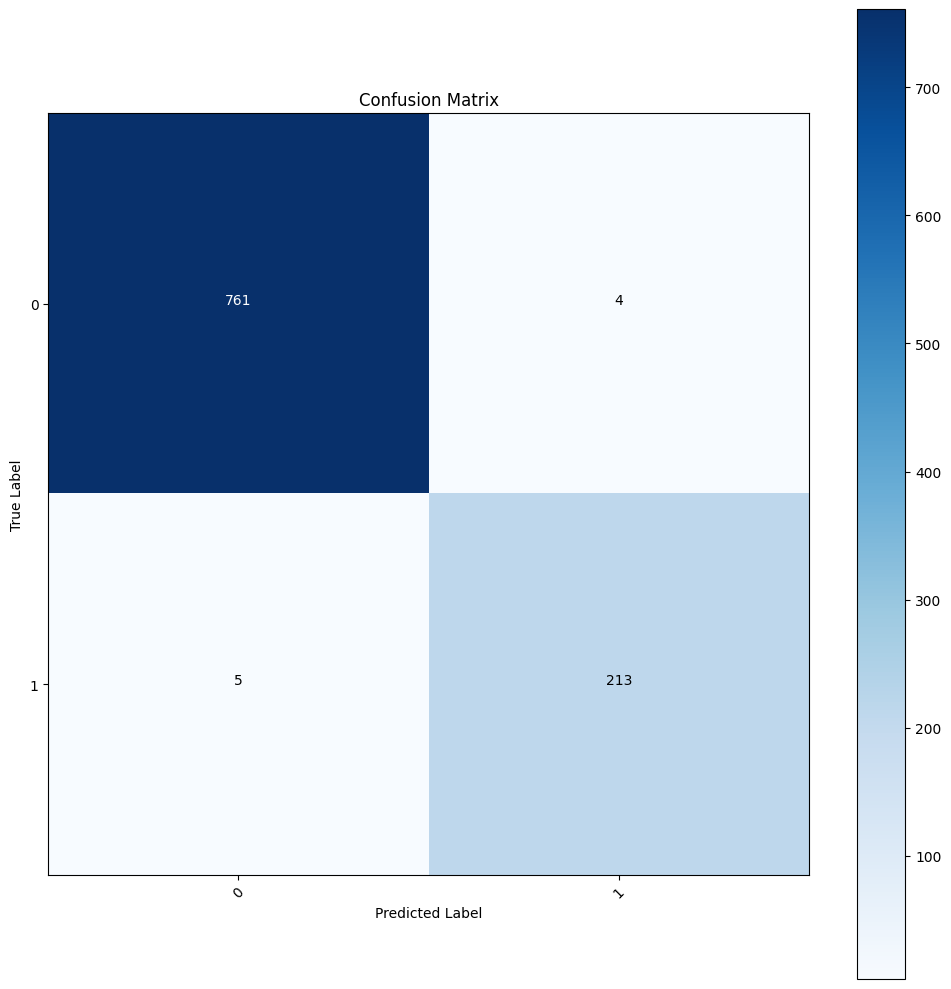

In [3]:
# # 生成混淆矩阵
# classes = list(set(y_test_true.values))
# y_test_pred_class = model.predict(df_test[num_feature_list])
# cm = confusion_matrix(y_test_true, y_test_pred_class)

# plt.figure(figsize=(10, 10))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

# plt.tight_layout()
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

In [4]:
y_test_pred_class

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

In [5]:
y_test_true

903     0
1472    0
4277    0
2335    0
7828    1
       ..
3713    0
7446    0
8378    1
6616    0
7116    0
Name: FLAG, Length: 983, dtype: int64